
# ViEWS 3 ensembles: future predictions
ViEWS monthly updates, cm level
Fatalities002 version

This notebook produces future predictions for a set of models defined in the list of dictionaries ModelList and the weights stored as iweights_df.csv. Both of these are produced by the notebook fatal_cm_compute_ensemble in this repository. 

The notebook draws on the following .py script files in this repository:

Ensembling.py

FetchData.py

ViewsEstimators.py

It also requires the list of models included in the ensemble, in the following file:

ModelDefinitions.py

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
import views_dataviz
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *

# Mapper
import geopandas as gpd

from views_dataviz.map import mapper, utils
from views_dataviz import color
from views_dataviz.map.presets import ViewsMap

import sqlalchemy as sa
#from ingester3.config import source_db_path

# Other packages
import pickle as pkl

#Parallelization
from joblib import Parallel, delayed, cpu_count
from functools import partial

from pathlib import Path

# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
sys.path.append('../SystemUpdates')
import os
from pathlib import Path

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated

from FetchData import FetchData, RetrieveFromList, ReturnQsList
from ViewsEstimators import *

In [14]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
RunGeneticAlgo = False
level = 'cm'
WriteToOverleaf = False
get_future = False

username = os.getlogin()

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

#steps = [1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,24] # Which steps to train and predict for
#fi_steps = [1,3,6,12,36] # Which steps to present feature importances for
#steps = [1,12,24,36]
fi_steps = [1,3,6,12,36]
#steps = [1,6,36]
#fi_steps = [1,6,36]

# Specifying partitions

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}
test_partitioner_dict = {"train":(121,444),"predict":(445,492)}
future_partitioner_dict = {"train":(121,492),"predict":(493,504)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

# Specifying paths - note these have to be set to conform to individual setups!

Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
localgitpath = f'/Users/{username}/views3/'
notebookpath = os.getcwd()
markovpath = str(Path(notebookpath).parent.absolute())+'/Tools/markov/'

if WriteToOverleaf:
    if EndOfHistory==508:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    if EndOfHistory==509:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    
    print('Overleaf path set to',overleafpath)

print('Dropbox path set to',Mydropbox)
print('Markov code path set to',markovpath)


Dropbox path set to /Users/chandlerwilliams/Dropbox (ViEWS)/ViEWS/
Markov code path set to /Users/chandlerwilliams/views3/viewsforecasting/Tools/markov/


# Retrieve models and predictions

In [15]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_baseline_rf baseline002
1 fatalities002_conflicthistory_rf conflict_ln
2 fatalities002_conflicthistory_gbm conflict_ln
3 fatalities002_conflicthistory_hurdle_lgb conflict_ln
4 fatalities002_conflicthistory_long_xgb conflictlong_ln
5 fatalities002_vdem_hurdle_xgb vdem_short
6 fatalities002_wdi_rf wdi_short
7 fatalities002_topics_rf topics_002
8 fatalities002_topics_xgb topics_002
9 fatalities002_topics_hurdle_lgb topics_002
10 fatalities002_joint_broad_rf joint_broad
11 fatalities002_joint_broad_hurdle_rf joint_broad
12 fatalities002_joint_narrow_xgb joint_narrow
13 fatalities002_joint_narrow_hurdle_xgb joint_narrow
14 fatalities002_joint_narrow_hurdle_lgb joint_narrow
15 fatalities002_all_pca3_xgb all_features
16 fatalities002_aquastat_rf aquastat
17 fatalities002_faostat_rf faostat
18 fatalities002_faoprices_rf faoprices
19 fatalities002_imfweo_rf imfweo
20 fat_hh20_Markov_glm joint_narrow
21 fat_hh20_Markov_rf joint_narrow


# Retrieve and calibrate predictions and data

In [16]:
## Running and saving David's models
# Import subprocess to run Rscript
import subprocess

# Fetch and save data (can perhaps be simplified?)
qs = Queryset('hh_20_features','country_month')
qs.fetch().to_parquet(markovpath + 'tmp.parquet')

# Set commands and arguments. R-scripts located in 'Markov'-folder
command ='Rscript'
#path2script ='../Tools/markov/omm_ranger_hh20_fcdo_py.R'
path2script = markovpath + 'omm_ranger_hh20_fcdo_py.R'

cmd = [command, path2script]
data_path = markovpath + 'tmp.parquet'
save_path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'
args = [str(EndOfHistory),data_path,save_path,]

# Run subprocess. Saves the predictions as csv-files to the save_path location with prefix vmm_[estimator]_hh20_[EndOfHistory]
subprocess.call(cmd+args)


 .    

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘arrow’

The following object is masked from ‘package:magrittr’:

    is_in

The following object is masked from ‘package:utils’:

    timestamp




 All required packages installed 

 Packages loaded, starting script 
24.491 sec elapsed
1 
23.96 sec elapsed
2 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


23.693 sec elapsed
3 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


23.577 sec elapsed
4 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.152 sec elapsed
5 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.103 sec elapsed
6 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.096 sec elapsed
7 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.624 sec elapsed
8 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.55 sec elapsed
9 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.7 sec elapsed
10 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.858 sec elapsed
11 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.777 sec elapsed
12 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.707 sec elapsed
13 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.932 sec elapsed
14 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.916 sec elapsed
15 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


25.004 sec elapsed
16 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.981 sec elapsed
17 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.971 sec elapsed
18 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


25.26 sec elapsed
19 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.948 sec elapsed
20 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.84 sec elapsed
21 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.824 sec elapsed
22 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.978 sec elapsed
23 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


25.022 sec elapsed
24 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.734 sec elapsed
25 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.539 sec elapsed
26 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.653 sec elapsed
27 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.623 sec elapsed
28 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.457 sec elapsed
29 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.57 sec elapsed
30 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.363 sec elapsed
31 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.372 sec elapsed
32 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.519 sec elapsed
33 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.395 sec elapsed
34 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.356 sec elapsed
35 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


24.262 sec elapsed
36 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
There were 50 or more warnings (use warnings() to see the first 50)


0

In [17]:
# Retrieve David's models from dropbox and store in prediction storage
path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'

DRList = [
    {
        'modelname': 'fat_hh20_Markov_glm',
        'filename': path + 'vmm_glm_hh20_' + str(EndOfHistory) + '.csv'
    },
    
    {
        'modelname': 'fat_hh20_Markov_rf',
        'filename': path + 'vmm_rf_hh20_' + str(EndOfHistory) + '.csv'
    }
]
    
for model in DRList:
    df_future = pd.read_csv(model['filename'],index_col=['month_id','country_id'])
    df_future['ln_ged_sb_dep'] = np.nan # Empty dependent variable column for consistency/required by prediction storage function
    stored_modelname = level + '_' + model['modelname'] + '_f' + str(EndOfHistory)
    df_future.forecasts.set_run(dev_id)
    df_future.forecasts.to_store(name=stored_modelname, overwrite=True)    

In [18]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, dev_id, level, get_future)

ModelList = CalibratePredictions(ModelList, EndOfHistory, steps)

0 fatalities002_baseline_rf
pr_46_cm_fatalities002_baseline_rf_calib.parquet
pr_46_cm_fatalities002_baseline_rf_test.parquet
1 fatalities002_conflicthistory_rf
pr_46_cm_fatalities002_conflicthistory_rf_calib.parquet
pr_46_cm_fatalities002_conflicthistory_rf_test.parquet
2 fatalities002_conflicthistory_gbm
pr_46_cm_fatalities002_conflicthistory_gbm_calib.parquet
pr_46_cm_fatalities002_conflicthistory_gbm_test.parquet
3 fatalities002_conflicthistory_hurdle_lgb
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_hurdle_lgb_test.parquet
4 fatalities002_conflicthistory_long_xgb
pr_46_cm_fatalities002_conflicthistory_long_xgb_calib.parquet
pr_46_cm_fatalities002_conflicthistory_long_xgb_test.parquet
5 fatalities002_vdem_hurdle_xgb
pr_46_cm_fatalities002_vdem_hurdle_xgb_calib.parquet
pr_46_cm_fatalities002_vdem_hurdle_xgb_test.parquet
6 fatalities002_wdi_rf
pr_46_cm_fatalities002_wdi_rf_calib.parquet
pr_46_cm_fatalities002_wdi_rf_test.parquet

In [19]:
# Run querysets and postprocessing (e.g. PCA) to obtain data for future prediction
qslist = ReturnQsList(level)
from FetchData import fetch_cm_data_from_model_def

Datasets=fetch_cm_data_from_model_def(qslist)

 .    fatalities002_baseline; A dataset with 6 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_topics_stub; A dataset with 62 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_aquastat_stub; A dataset with 11 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_cm_conflict_history_stub; A dataset with 24 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_cm_conflict_history_ext; A dataset with 33 columns, with data between t = 1 and 852. (213 units)
 .    fatalities002_vdem_short_stub; A dataset with 57 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_wdi_short_stub; A dataset with 28 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_joint_narrow; A dataset with 39 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_joint_broad_stub; A dataset with 102 columns, with data between t 1 and 852. (213 units)
 .    fatalities002_faostat_stub;A

In [ ]:
# EndOfHistory can be reset here to facilitate rerunning several months without rereading input data
# Remove '#' and reset
#EndOfHistory = 506

In [20]:


from views_runs import Storage, StepshiftedModels
from views_partitioning.data_partitioner import DataPartitioner
from viewser import Queryset, Column
from views_runs import operations
from views_runs.run_result import RunResult

from pygam import LogisticGAM, LinearGAM, s, te

RewritePredictions = False # Set this to True to rewrite predictions even if they exist

def RetrainAndPredict(modelname):
    force_retrain = False
    modelstore = storage.Storage()
    # Predictions for true future
    ct = datetime.now()
    print('Future', ct)
    modelstore = storage.Storage()
    model['RunResult_future']  = RunResult.retrain_or_retrieve(
            retrain            = force_retrain,
            store              = modelstore,
            partitioner        = DataPartitioner({"test":future_partitioner_dict}),
            stepshifted_models = StepshiftedModels(model['algorithm'], steps, model['depvar']),
            dataset            = RetrieveFromList(Datasets,model['data_train']),
            queryset_name      = model['queryset'],
            partition_name     = "test",
            timespan_name      = "train",
            storage_name       = model['modelname'] + '_future',
            author_name        = "HH",
    )       
    predictions_future = model['RunResult_future'].run.future_point_predict(EndOfHistory,model['RunResult_future'].data)
    return predictions_future



i = 0
print('Computing predictions, production run ' + prod_id + ', development run ' + dev_id)
for model in ModelList:

    # Loop that checks whether (1) this a model trained outside the main system, 
    # (2) retrieves the prediction if it exists in prediction storage,
    # (3) if not checks whether the trained model exists, retrains if not, 
    # Then calibrates the predictions and stores them if they have not been stored before for this run.
    # To do: set the data_preprocessing to the function in the model dictionary
    
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    
    if 'Markov' not in model['modelname']: # Only Markov models are currently exceptions
        print(i, model['modelname'])

        ct = datetime.now()
        print('Trying to retrieve non-calibrated predictions', ct)
        if RewritePredictions:
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])
        else:
            try:
                model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
                print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

            except KeyError:
                print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
                model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

        # Calibrating and storing   
        # Storing non-calibrated
        
        model['future_df_noncalibrated'].forecasts.set_run(run_id)
        model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True)   
        print('Calibrating')
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
        for step in steps:
            thismonth = EndOfHistory + step
            
            model['future_df_calibrated'].loc[thismonth,'step_combined'] = pd.DataFrame(model['calibration_gams'][step-1]['calibration_GAM'].predict(model['future_df_noncalibrated'].loc[thismonth])).values
         # Storing calibrated
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   
            
    else: # If one of David's Markov models
        print(i, model['modelname'])
            
        model['predstorename_noncalibrated'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
        print(model['predstorename_noncalibrated'], ', run', run_id, 'is being retrieved from dropbox')
        path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'

        if model['modelname'] == 'fat_hh20_Markov_glm':
            DR_filename = path + 'vmm_glm_hh20_' + str(EndOfHistory) + '.csv'
            model['future_df_calibrated'] = pd.read_csv(DR_filename,index_col=['month_id','country_id'])
        if model['modelname'] == 'fat_hh20_Markov_rf':
            DR_filename = path + 'vmm_rf_hh20_' + str(EndOfHistory) + '.csv'
            model['future_df_calibrated'] = pd.read_csv(DR_filename,index_col=['month_id','country_id'])
            
        model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   


    i = i + 1

print('All done')
        
        

Computing predictions, production run 2022_04_t01, development run Fatalities002
0 fatalities002_baseline_rf
Trying to retrieve non-calibrated predictions 2022-10-17 15:28:59.457177
pr_46_cm_fatalities002_baseline_rf_noncalibrated_f509.parquet
Predictions for  cm_fatalities002_baseline_rf_noncalibrated_f509 , run Fatalities002 exist, retrieving from prediction storage
Calibrating
1 fatalities002_conflicthistory_rf
Trying to retrieve non-calibrated predictions 2022-10-17 15:29:17.306506
pr_46_cm_fatalities002_conflicthistory_rf_noncalibrated_f509.parquet
Predictions for  cm_fatalities002_conflicthistory_rf_noncalibrated_f509 , run Fatalities002 exist, retrieving from prediction storage
Calibrating
2 fatalities002_conflicthistory_gbm
Trying to retrieve non-calibrated predictions 2022-10-17 15:29:43.764182
pr_46_cm_fatalities002_conflicthistory_gbm_noncalibrated_f509.parquet
Predictions for  cm_fatalities002_conflicthistory_gbm_noncalibrated_f509 , run Fatalities002 exist, retrieving from

In [21]:
i=0
for ds in Datasets:
    print(i,ds['Name'])
    i = i + 1

0 wdi_short
1 baseline002
2 aquastat
3 topics_002
4 imfweo
5 joint_narrow
6 conflict_ln
7 faoprices
8 vdem_short
9 faostat
10 all_features
11 conflictlong_ln
12 joint_broad
13 pca_all
14 pca_topics
15 pca_vdem
16 pca_wdi


In [22]:
df = Datasets[7]['df']
df.head()
#df.loc[508]['general_efficiency_t48'].describe()

fao_wheat_price  fao_mp_price  fao_sugar_price  \
month_id country_id                                                   
1        1                       0.0           0.0              0.0   
         2                       0.0           0.0              0.0   
         3                       0.0           0.0              0.0   
         4                       0.0           0.0              0.0   
         5                       0.0           0.0              0.0   

                     fao_meat_price  fao_milk_price  ln_ged_sb_dep  ln_ged_sb  \
month_id country_id                                                             
1        1                      0.0             0.0            0.0        0.0   
         2                      0.0             0.0            0.0        0.0   
         3                      0.0             0.0            0.0        0.0   
         4                      0.0             0.0            0.0        0.0   
         5                      0.0             0.0            0.0        0.0   

                     gleditsch_ward  delta_fao_wheat_price  \
month_id country_id                                          
1        1                    110.0                    0.0   
         2                    115.0                    0.0   
         3                     52.0                    0.0   
         4                    101.0                    0.0   
         5                    990.0                    0.0   

                     delta_fao_mp_price  delta_fao_sugar_price  \
month_id country_id                                              
1        1                          0.0                    0.0   
         2                          0.0                    0.0   
         3                          0.0                    0.0   
         4                          0.0                    0.0   
         5                          0.0                    0.0   

                     delta_fao_meat_price  delta_fao_milk_price  \
month_id country_id                                               
1        1                            0.0                   0.0   
         2                            0.0                   0.0   
         3                            0.0                   0.0   
         4                            0.0                   0.0   
         5                            0.0                   0.0   

                     wdi_sp_pop_totl  decay_ged_sb_5  decay_ged_os_5  \
month_id country_id                                                    
1        1                  780153.0             0.0             0.0   
         2                  359531.0             0.0             0.0   
         3                 1084744.0             0.0             0.0   
         4                15182611.0             0.0             0.0   
         5                  155525.0             0.0             0.0   

                     splag_1_decay_ged_sb_5  
month_id country_id                          
1        1                              0.0  
         2                              0.0  
         3                              0.0  
         4                              0.0  
         5                              0.0

In [23]:
EnsembleList = [] # Separate list of dictionaries for ensembles!

Ensemble = {
    'modelname':            'genetic_ensemble',
    'algorithm':            [],
    'depvar':               'ln_ged_sb_dep',
    'data_train':           [],
    'Algorithm_text':       '',
    'calibration_gams':     [],
    'future_df_calibrated': [],
}
EnsembleList.append(Ensemble)


In [26]:
# Collecting in one df, one column per model
ConstituentModels_df = pd.DataFrame(ModelList[0]['future_df_calibrated']['step_combined'])
ConstituentModels_df.columns = [ModelList[0]['modelname']]
for model in ModelList[1:]:
    ConstituentModels_df[model['modelname']] = pd.DataFrame(model['future_df_calibrated']['step_combined'])


In [27]:
# Retrieve genetic algorithm results
i_weights_df = pd.read_csv('../Intermediates/GeneticWeights.csv')

# Retrieve ensemble predictions for test partition to create categorical predictions

In [28]:
stored_modelname_test = level + '_' + 'ensemble_genetic' + '_test'

ensemble_test_df = pd.DataFrame.forecasts.read_store(stored_modelname_test, run=run_id)
ensemble_test_df.replace([np.inf, -np.inf], 0, inplace=True)  

ensemble_test_df.head()

pr_46_cm_ensemble_genetic_test.parquet


ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
445      1                     0.0     0.005352     0.006032     0.036104   
         2                     0.0     0.006328     0.005449     0.031227   
         3                     0.0     0.004876     0.004701     0.003081   
         4                     0.0     0.005919     0.006264     0.008694   
         5                     0.0     0.005951     0.004576     0.008105   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
445      1              0.006551     0.008710     0.009211     0.014754   
         2              0.005361     0.007036     0.009166     0.011328   
         3              0.003862     0.004985     0.006483     0.006760   
         4              0.006989     0.011231     0.012538     0.013310   
         5              0.004331     0.006397     0.007042     0.008671   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
445      1              0.014403     0.013317  ...      0.084057   
         2              0.015408     0.013070  ...      0.043899   
         3              0.010068     0.009761  ...      0.035037   
         4              0.020956     0.017720  ...      0.057515   
         5              0.012852     0.009450  ...      0.045273   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
445      1               0.098729      0.146694      0.111655      0.162419   
         2               0.045991      0.057028      0.051526      0.052432   
         3               0.041445      0.040403      0.051587      0.052448   
         4               0.070227      0.076700      0.112692      0.116600   
         5               0.043101      0.061003      0.057133      0.055112   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                                           
445      1               0.119925      0.172456      0.114012      0.152184   
         2               0.045582      0.042155      0.046065      0.061007   
         3               0.045081      0.040427      0.042408      0.053962   
         4               0.114357      0.108172      0.143277      0.124714   
         5               0.046421      0.046830      0.047814      0.059044   

                     step_pred_36  
month_id country_id                
445      1               0.169459  
         2               0.063526  
         3               0.056820  
         4               0.164577  
         5               0.060289  

[5 rows x 37 columns]

In [29]:
# Generate dichotomous version of dependent variable
ensemble_test_df['ged_gte_25'] = ensemble_test_df['ln_ged_sb_dep'].apply(lambda x: 1 if x >= np.log1p(25) else 0)
# Generate multiclass version for uncertainty estimation
def ged_categorical(x):
    if x < np.log1p(0.5):
        return 0
    elif x < np.log1p(10):
        return 1
    elif x < np.log1p(100):
        return 2
    elif x < np.log1p(1000):
        return 3
    else :
        return 4

ensemble_test_df['ged_multi'] = ensemble_test_df['ln_ged_sb_dep'].apply(ged_categorical)

ensemble_test_df.describe()

,ln_ged_sb_dep,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,...,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ged_gte_25,ged_multi
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,...,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000
mean,0.498353,0.570969,0.628956,0.667081,0.688486,0.682289,0.700750,0.694528,0.706906,0.725277,...,0.849666,0.824139,0.849094,0.845087,0.848999,0.842459,0.828961,0.824170,0.075698,0.291121
std,1.368332,1.426773,1.537472,1.589267,1.684517,1.613578,1.707656,1.654649,1.670112,1.710433,...,1.720794,1.641991,1.681639,1.698334,1.693675,1.697292,1.687045,1.687022,0.264529,0.766228
min,0.000000,0.003085,0.003564,0.002908,0.003569,0.004520,0.006077,0.005472,0.008742,0.008907,...,0.016628,0.025840,0.027857,-0.005982,-0.003342,-0.026751,0.025131,0.041491,0.000000,0.000000
25%,0.000000,0.005943,0.006369,0.009038,0.006737,0.008179,0.010357,0.011690,0.015944,0.014538,...,0.060040,0.055988,0.057709,0.051558,0.050617,0.051792,0.063311,0.065100,0.000000,0.000000
50%,0.000000,0.009477,0.016518,0.032781,0.020902,0.023144,0.024222,0.028298,0.036579,0.036093,...,0.096944,0.088281,0.096738,0.107018,0.104938,0.107000,0.101482,0.100419,0.000000,0.000000
75%,0.000000,0.059981,0.149033,0.193458,0.171631,0.188964,0.214271,0.206372,0.244496,0.288866,...,0.466784,0.443616,0.446511,0.445307,0.457550,0.449798,0.417035,0.388627,0.000000,0.000000
max,8.698181,8.832977,12.019380,12.467754,15.340246,12.522342,15.369025,13.829173,16.105506,17.180821,...,10.178789,9.803621,9.538641,9.831323,9.905181,9.663446,10.031043,9.563496,1.000000,4.000000


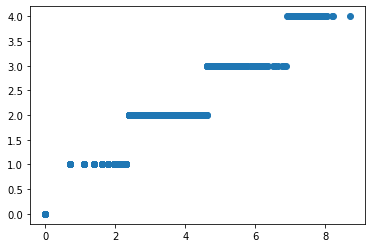

In [30]:
plt.scatter(ensemble_test_df['ln_ged_sb_dep'],ensemble_test_df['ged_multi'])

In [31]:
# Train model to transform predictions from  fatalities to (1) dichotomous and (2) multiclass
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
dichotomous_classifiers = []
multi_classifiers = []
for step in steps:
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Dichotomous
    y_dich = np.array(ensemble_test_df['ged_gte_25']).reshape(-1, 1)
    dich_clf = LogisticRegression(random_state=0).fit(X, y_dich)
    p_dich = dich_clf.predict_proba(X)
    ensemble_test_df[f'dich_step_{step}_logit'] = p_dich[:,1].ravel()
    # Calibrated
    calibrated_dich_clf = CalibratedClassifierCV(base_estimator=dich_clf, cv=3)
    calibrated_dich_clf.fit(X, y_dich)
    p_dich_cal = calibrated_dich_clf.predict_proba(X)
    dichotomous_classifiers.append(calibrated_dich_clf)
    ensemble_test_df[f'dich_cal_step_{step}_logit'] = p_dich_cal[:,1].ravel()
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    p_multi = multi_clf.predict_proba(X)
    for cls in [0,1,2,3,4]:
        ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()

ensemble_test_df[['dich_step_3_logit','dich_cal_step_3_logit']].describe()

,dich_step_3_logit,dich_cal_step_3_logit
count,9168.000000,9168.000000
mean,0.075698,0.075701
std,0.225086,0.223994
min,0.003167,0.003445
25%,0.003197,0.003477
50%,0.003315,0.003603
75%,0.004236,0.004582
max,0.999998,0.999998


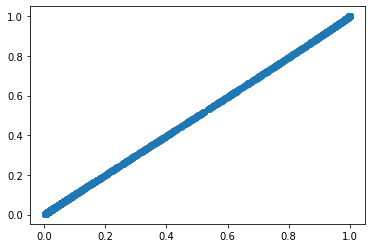

In [32]:
plt.scatter(ensemble_test_df['dich_step_3_logit'],ensemble_test_df['dich_cal_step_3_logit'])

# Calculating and storing ensemble future predictions

In [33]:
# Setting up a placeholder df for ensemble predictions
EnsembleList[0]['future_df_calibrated'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline
EnsembleList[0]['future_df_dichotomous'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline

ConstituentModels_df_w = ConstituentModels_df.copy()

for step in steps:
    month = EndOfHistory + step
    weightcol = 'step_pred_' + str(step)
    weights = np.array(pd.DataFrame(i_weights_df[weightcol]))
    EnsembleList[0]['future_df_calibrated'].loc[month] = ConstituentModels_df_w.loc[month].dot(weights).values
    x_d = np.array(EnsembleList[0]['future_df_calibrated'].loc[month]).reshape(-1,1)
    pred_step = dichotomous_classifiers[step-1].predict_proba(x_d)
    EnsembleList[0]['future_df_dichotomous']['step_combined'].loc[month] = pred_step[:,1]

In [34]:
# Storing the ensemble future predictions
predstore_future = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory)
EnsembleList[0]['future_df_calibrated'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_calibrated'].forecasts.to_store(name=predstore_future, overwrite = True) 
predstore_future_dich = level +  '_' + EnsembleList[0]['modelname'] + '_dich_f' + str(EndOfHistory)
EnsembleList[0]['future_df_dichotomous'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_dichotomous'].forecasts.to_store(name=predstore_future_dich, overwrite = True) 


In [35]:
ViewsMetadata().with_name('genetic').fetch()

,id,name,file_name,runs_id,model_generations_id,user_name,spatial_loa,temporal_loa,ds,osa,time_min,time_max,space_min,space_max,steps,target,prediction_columns,date_written,description,deleted
0,1137,cm_ensemble_genetic_f505,pr_33_cm_ensemble_genetic_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-03-19 08:09:49.362072+00:00,None,False
1,12013,cm_ensemble_genetic_exp_exp_calib,pr_33_cm_ensemble_genetic_exp_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:27.861484+00:00,None,False
2,12014,cm_ensemble_genetic_exp_exp_test,pr_33_cm_ensemble_genetic_exp_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:34.024314+00:00,None,False
3,12017,cm_ensemble_genetic_exp_calib,pr_33_cm_ensemble_genetic_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:40:57.763694+00:00,None,False
4,12018,cm_ensemble_genetic_exp_test,pr_33_cm_ensemble_genetic_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:41:06.365460+00:00,None,False
5,12110,cm_genetic_ensemble_f503,pr_33_cm_genetic_ensemble_f503.parquet,33,1,hh,c,m,False,False,504,539,1,246,[],step_combined,[],2022-04-27 06:28:50.198353+00:00,None,False
6,12141,cm_genetic_ensemble_f505,pr_33_cm_genetic_ensemble_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-04-27 06:50:05.853414+00:00,None,False
7,12173,cm_ensemble_genetic_calib,pr_33_cm_ensemble_genetic_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:18.202727+00:00,None,False
8,12174,cm_ensemble_genetic_test,pr_33_cm_ensemble_genetic_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:26.273595+00:00,None,False
9,12716,cm_genetic_ensemble_f506,pr_33_cm_genetic_ensemble_f506.parquet,33,1,jim,c,m,False,False,507,542,1,246,[],step_combined,[],2022-05-09 16:10:06.894731+00:00,None,False


# Mapping future predictions [cells under this heading will be deleted when present_results.ipynb is ready]

In [36]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

from views_dataviz import color
from views_dataviz.map import utils
from views_dataviz.map.presets import ViewsMap

import sqlalchemy as sa
#from ingester3.config import source_db_path
#from ingester3.Country import Country
#from ingester3.extensions import *
#from ingester3.ViewsMonth import ViewsMonth

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
import numpy as np

class Mapper2:
    """
    `Map` takes basic properties and allows the user to consecutively add
    layers to the Map object. This makes it possible to prepare mapping
    "presets" at any level of layeredness that can be built on further.
    
    Mapper2 allows for the customizable addition of scaling to the map. 
    -re-add the code for labels later when i can test it

    Attributes
    ----------
    width: Integer value for width in inches.
    height: Integer value for height in inches.
    bbox: List for the bbox per [xmin, xmax, ymin, ymax].
    frame_on: Bool for whether to draw a frame around the map.
    title: Optional default title at matplotlib's default size.
    figure: Optional tuple of (fig, size) to use if you want to plot into an
        already existing fig and ax, rather than making a new one.
    """

    def __init__(
        self,
        width,
        height,
        bbox=None,
        cmap=None,
        frame_on=True,
        title="",  # Default title without customization. (?)
        figure=None,
    ):
        self.width = width
        self.height = height
        self.bbox = bbox  # xmin, xmax, ymin, ymax
        self.cmap = cmap
        if figure is None:
            self.fig, self.ax = plt.subplots(figsize=(self.width, self.height))
        else:
            self.fig, self.ax = figure
        self.texts = []
        self.ax.set_title(title)

        if frame_on:  # Remove axis ticks only.
            self.ax.tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
            )
        else:
            self.ax.axis("off")

        if bbox is not None:
            self.ax.set_xlim((self.bbox[0], self.bbox[1]))
            self.ax.set_ylim((self.bbox[2], self.bbox[3]))

    def add_layer(self, gdf, map_scale=False, map_dictionary=False, cmap=None, inform_colorbar=False, **kwargs):
        """Add a geopandas plot to a new layer.

        Parameters
        ----------
        gdf: Geopandas GeoDataFrame to plot.
        cmap: Optional matplotlib colormap object or string reference
            (e.g. "viridis").
        inform_colorbar: Set or overwrite colorbar with the current layer.
            Not applicable when `color` is supplied in the kwargs.
        map_scale: set a manual scale for the map. If missing defaults to the Remco procedure. 
        map_dictionary: set manual labels for the map. If missing defaults to the default labels.
        **kwargs: Geopandas `.plot` keyword arguments.
        """
        if "color" in kwargs:
            colormap = None
        else:
            colormap = self.cmap if cmap is None else cmap
            if inform_colorbar and "column" in kwargs:
                if hasattr(self, "cax"):
                    self.cax.remove()
                if "vmin" not in kwargs:
                    self.vmin = gdf[kwargs["column"]].min()
                else:
                    self.vmin = kwargs["vmin"]
                if "vmax" not in kwargs:
                    self.vmax = gdf[kwargs["column"]].max()
                else:
                    self.vmax = kwargs["vmax"]
        
        try: Mapper2.add_colorbar(self, colormap, min(map_scale), max(map_scale))
        except: Mapper2.add_colorbar(self, colormap, self.vmin, self.vmax)
        
        try:
            self.ax = gdf.plot(ax=self.ax, cmap=colormap, vmin=min(map_scale), vmax=max(map_scale), **kwargs)
        except: 
            self.ax = gdf.plot(ax=self.ax, cmap=colormap, **kwargs)

                
        return self
    
    def add_colorbar(
        self,
        cmap,
        vmin,
        vmax,
        location="right",
        size="5%",
        pad=0.1,
        alpha=1,
        labelsize=16,
        tickparams=None,
    ):
        """Add custom colorbar to Map.

        Needed since GeoPandas legend and plot axes do not align, see:
        https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html

        Parameters
        ----------
        cmap: Matplotlib colormap object or string reference (e.g. "viridis").
        vmin: Minimum value of range colorbar.
        vmax: Maximum value of range colorbar.
        location: String for location of colorbar: "top", "bottom", "left"
            or "right".
        size: Size in either string percentage or number of pixels.
        pad: Float for padding between the plot's frame and colorbar.
        alpha: Float for alpha to apply to colorbar.
        labelsize: Integer value for the text size of the ticklabels.
        tickparams: Dictionary containing value-label pairs. For example:
            {0.05: "5%", 0.1: "10%"}
        """
        norm = plt.Normalize(vmin, vmax)
        if isinstance(cmap, str):
            cmap = plt.get_cmap(cmap)
        cmap = color.force_alpha_colormap(cmap=cmap, alpha=alpha)
        scalar_to_rgba = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        divider = make_axes_locatable(self.ax)
        self.cax = divider.append_axes(location, size, pad)
        self.cax.tick_params(labelsize=labelsize)
        tickvalues = (
            list(tickparams.keys()) if tickparams is not None else None
        )
        self.cbar = plt.colorbar(
            scalar_to_rgba, cax=self.cax, ticks=tickvalues
        )
        if tickparams is not None:
            self.cbar.set_ticklabels(list(tickparams.values()))
        return self
    
    def save(
        self, path, dpi=200, **kwargs
    ):  # Just some defaults to reduce work.
        """Save Map figure to file.
        Parameters
        ----------
        path: String path, e.g. "./example.png".
        dpi: Integer dots per inch. Increase for higher resolution figures.
        **kwargs: Matplotlib `savefig` keyword arguments.
        """
        self.fig.savefig(path, dpi=dpi, bbox_inches="tight", **kwargs)
        plt.close(self.fig)
        
def vid2date(i):
    year=str(1980 + i//12)
    month=str(i%12)
    return year+'/'+month
        
#def vid2date(i):
#    year=str(ViewsMonth(i).year)
#    month=str(ViewsMonth(i).month)
#    return year+'/'+month

#note the zip function occured earlier
standard_scale = [np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100),  np.log1p(300), np.log1p(1000), np.log1p(3000),  np.log1p(10000)]
standard_scale_labels = ['0', '3','10', '30','100', '300', '1000', '3000', '10000']

small_scale=[np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100),  np.log1p(300), np.log1p(1000)]


small_scale_labels = ['0', '3','10', '30','100', '300', '1000']

small_scale_nolabels = ['', '','', '','', '', '']

In [37]:
# Prepare the gdf
gdf_base = gpd.read_parquet('../Tools/geometry/cm_geometry.parquet')
gdf = gdf_base.copy()

In [38]:
# Future prediction maps, predictions, rolling
path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/'
stepstoplot=[3,5,8,12,24,36]
#titles = [vid2date(i) for i in stepstoplot + EndOfHistory]


df = EnsembleList[0]['future_df_calibrated'].copy()
gdf2 = gdf_base.copy()
df = df.join(gdf2.set_index("country_id"))
gdf3 = gpd.GeoDataFrame(df, geometry="geom")

In [39]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column='step_combined', 
        inform_colorbar=True
        )
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)
        if WriteToOverleaf:
            m.save(f'{overleafpath}PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')
#        except:
#            print('Overleaf/dropbox folder not found')
        m.save(f'{path}PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

## Retrain the surrogate models

In [ ]:
Datasets[1]['df'].loc[544]

In [ ]:
for i in Datasets:
    print(i['Name'])

s1 Conflict history
s1 Democracy
s1 Rule of law
s1 Population
s1 Infant mortality
s1 Neighborhood conflict
s1 Topics: conflict and conflict stock
s1 Water services efficiency
s2 Conflict history
s2 Democracy
s2 Rule of law
s2 Population
s2 Infant mortality
s2 Neighborhood conflict
s2 Topics: conflict and conflict stock
s2 Water services efficiency
s3 Conflict history
s3 Democracy
s3 Rule of law
s3 Population
s3 Infant mortality
s3 Neighborhood conflict
s3 Topics: conflict and conflict stock
s3 Water services efficiency
s4 Conflict history
s4 Democracy
s4 Rule of law
s4 Population
s4 Infant mortality
s4 Neighborhood conflict
s4 Topics: conflict and conflict stock
s4 Water services efficiency
s5 Conflict history
s5 Democracy
s5 Rule of law
s5 Population
s5 Infant mortality
s5 Neighborhood conflict
s5 Topics: conflict and conflict stock
s5 Water services efficiency
s6 Conflict history
s6 Democracy
s6 Rule of law
s6 Population
s6 Infant mortality
s6 Neighborhood conflict
s6 Topics: conflic

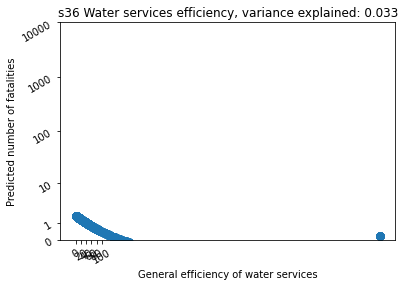

In [40]:
from cm_surrogatemodels import TrainSurrogateModels
SurrogateModelSteps = [1,3,6,36]
SurrogateModelSteps = steps
EndOfHistory_test = test_partitioner_dict['train'][1] 
Plotpath = Mydropbox + 'Projects/PredictingFatalities/SurrogateModels/'


       
SurrogateModelList = TrainSurrogateModels(data_df = Datasets[10]['df'], 
                                          Ensemble_df = ensemble_test_df, 
                                          EndOfHistory = EndOfHistory_test, 
                                          SurrogateModelSteps = SurrogateModelSteps, 
                                          NumberOfMonths = 48,
                                          Plotpath = Plotpath)


In [41]:
SurrogateModelList[0]

{'Modelname': 's1 Conflict history',
 'Shortname': 'CH',
 'Longdescription': 'Predicted fatalities in state-based conflict per country-month, given the history of state-based conflict (as recorded by the UCDP GED datasets) in the country at hand. Expressed as natural log(fatalities+1). The prediction is generated by a ‘surrogate’/interpretation model that shows how much of the main VIEWS conflict prediction can be related to variable `ln_ged_sb_dep` — in practice, a regression model with the main prediction as the dependent variable and a flexible function of `ln_ged_sb_dep` as the independent one. The surrogate model results should be seen as an indication of the relative importance of specific independent variables (predictors), rather than point predictions of their own – they do not sum up to the point predictions from the main ensemble model. To learn more about the surrogate models, please see https://www.diva-portal.org/smash/get/diva2:1667048/FULLTEXT01.pdf',
 'Step': 1,
 'Colu

In [42]:
predictors_df = Datasets[10]['df'].loc[EndOfHistory]

EnsembleList[0]['future_df_surrogates'] = EnsembleList[0]['future_df_calibrated'].copy()
# Initialize dataframe to hold surrogate model predictions:
for item in SurrogateModelList:
    if item['Step'] == 1:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        EnsembleList[0]['future_df_surrogates'][colname] = np.nan  
# Compute predictions for each step
for step in steps:
    month = EndOfHistory + step
#    print('Step',step,'Month',month)
    for item in SurrogateModelList:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        if item['Step']==step:
#            print('colname:',colname,'Step:',item['Step'], item['Columns'])
            EnsembleList[0]['future_df_surrogates'][colname].loc[month] = item['GAM'].predict(predictors_df[item['Columns']])

# Storing the surrogate model future predictions
api_definition = []
for item in SurrogateModelList:
    if item['Step'] == 36:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        predstore_future = level +  '_surrogate_' + item['Shortname'] + '_f' + str(EndOfHistory)
        print('Storing surrogate model predictions for model',colname, 'as:',predstore_future)
        predictions_to_store = pd.DataFrame(EnsembleList[0]['future_df_surrogates'][colname])
        predictions_to_store.forecasts.set_run(run_id)
        predictions_to_store.forecasts.to_store(name=predstore_future, overwrite = True) 
        api_item = {
            'Dev_id': dev_id,
            'EndOfHistory': EndOfHistory,
            'Model': colname,
            'Prediction storage colname': predstore_future
        }
        api_definition.append(api_item)

api_definition

Storing surrogate model predictions for model Conflict history as: cm_surrogate_CH_f509
Storing surrogate model predictions for model Democracy as: cm_surrogate_Dem_f509
Storing surrogate model predictions for model Rule of law as: cm_surrogate_Rule_f509
Storing surrogate model predictions for model Population as: cm_surrogate_Pop_f509
Storing surrogate model predictions for model Infant mortality as: cm_surrogate_IMR_f509
Storing surrogate model predictions for model Neighborhood conflict as: cm_surrogate_NCH_f509
Storing surrogate model predictions for model Topics: conflict and conflict stock as: cm_surrogate_Topic10_f509
Storing surrogate model predictions for model Water services efficiency as: cm_surrogate_Water_f509


[{'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Conflict history',
  'Prediction storage colname': 'cm_surrogate_CH_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Democracy',
  'Prediction storage colname': 'cm_surrogate_Dem_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Rule of law',
  'Prediction storage colname': 'cm_surrogate_Rule_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Population',
  'Prediction storage colname': 'cm_surrogate_Pop_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Infant mortality',
  'Prediction storage colname': 'cm_surrogate_IMR_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Neighborhood conflict',
  'Prediction storage colname': 'cm_surrogate_NCH_f509'},
 {'Dev_id': 'Fatalities002',
  'EndOfHistory': 509,
  'Model': 'Topics: conflict and conflict stock',
  'Prediction storage colname': 'cm_surrogate_Topic10_f509'},
 {'

In [44]:
import json
with open( '../Intermediates/api_defintion.json', 'w') as api_file:
    json.dump(api_definition,api_file)

In [45]:
for model in SurrogateModelList:
    if model['Step'] == 1:
        print(model['Modelname'])
        
#for model in SurrogateModelList:
#    if model['Step'] == 1:
#        print(model['Modelname'], model['Shortname'], model['Longdescription'], model['Columns'])

s1 Conflict history
s1 Democracy
s1 Rule of law
s1 Population
s1 Infant mortality
s1 Neighborhood conflict
s1 Topics: conflict and conflict stock
s1 Water services efficiency


In [ ]:
# Mapping

predictors_df = Datasets[10]['df'].loc[EndOfHistory]
predictors_df_3m = Datasets[10]['df'].loc[EndOfHistory-3]

path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/Surrogate/'
surrogate_scale=[np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100), np.log1p(300)]

surrogate_scale_labels = ['', '','', '', '', '']

MapSteps = [1,3,6,12,36]
for model in SurrogateModelList:
    if model['Step'] in MapSteps:
        print(model['Modelname'], model['Columns'])

        df = predictors_df[model['Columns']]
        df[model['Predcolname']] = model['GAM'].predict(predictors_df[model['Columns']])
        gdf2 = gdf_base.copy()
        df = df.join(gdf2.set_index("country_id"))
        gdf3 = gpd.GeoDataFrame(df, geometry="geom")
        Predcolname = model['Predcolname']
        step = model['Step']
        TargetMonth = EndOfHistory+step

        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Surrogate model ' + model['Modelname'] + ' predictions as of ' + vid2date(TargetMonth) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf3,
        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=model['Predcolname'], 
        inform_colorbar=True
        )
        m.cbar.set_ticks(surrogate_scale)
        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(f'{path}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')
        if WriteToOverleaf:
            m.save(f'{overleafpath}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')


# Documentation

In [46]:
import pickle
with open('surrogate_models.p','wb') as f:
    pickle.dump(SurrogateModelList, f)

In [48]:
def document_surrogate(surrogate_model_list, path):
    """
    Write a markdown definition of a surrogate model list to file.
    :param surrogate_model_list: A ViEWS surrogate models list, being a dictionary containing at least a modelname, a shortname, a longdescription and a colums object
    :param path: A path to write the markdown documentation to.
    :return: None
    """
    
    i = 0
    SurrogateMetaData = []
    for model in SurrogateModelList:
        if model['Step'] == 1:
            print(i, model['Modelname'], model['Shortname'], model['Longdescription'], model['Columns'])
            SurrogateModelMetaData = {
                'Model name': model['Modelname'],
                'Short Description': model['Shortname'],
                'Long Description': model['Longdescription'],
                'Columns': model['Columns']
            }
        
            SurrogateMetaData.append(SurrogateModelMetaData)
            i = i + 1
            SurrogateMetaData_df = pd.DataFrame(SurrogateMetaData)
            filename = f'{path}SurrogateModelsDefined.md'
            SurrogateMetaData_df.to_markdown(index=False, buf=filename)

# This function defines the surrogate models and creates a markdown file 

In [108]:
from FetchData import SurrogateMetadata

In [109]:
metadata = SurrogateMetadata(SurrogateModelList)
metadata.surrogate_model_list
metadata.to_markdown(path=path+'x.Md')

In [119]:
'C:\path\to\ocument'.rstrip('./')+'/'+'x.php'

'C:\\path\to\\ocument/x.php'

In [120]:
!open -a Terminal

In [ ]:
from cm_surrogatemodels import DefineSurrogateModels

SurrogateModelList = DefineSurrogateModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

In [ ]:
# Once the above is moved into the FetchData.py file, this command should do what we need: 

from FetchData import document_surrogate

SurrogateModels = document_surrogate(SurrogateModelList)

In [ ]:
# Attempt 3. This may be the actual thing we need. If so, no real need for the above cells that were added. 

from SurrogateModelDefinitions import DefineSurrogateModels

Surrogate_List = DefineSurrogateModels(level)
    
i = 0
for model in Surrogate_List:
    print(i, model['Name'], model['Shortname'], model['Longdescription'], model['Columns'])
    i = i + 1
    
    
SurrogateModels_df = pd.DataFrame(Surrogate_List)
        filename = f'../Documentation/Surrogate_List{outcome}.md'
        SurrogateModles_df.to_markdown(index=False, buf=filename)

In [ ]:
SurrogateModelMetaData = {
            'Model name': model['Modelname'],
            'Short Description': model['Shortname'],
            'Long Description': model['Longdescription'],
            'Columns': model['Columns']
        }

In [ ]:
SurrogateModelMetaData

In [ ]:
# I need this without the s1, and then into a md file

for model in SurrogateModelList:
    if model['Step'] == 1:
        print(model['Modelname'], model['Shortname'], model['Longdescription'], model['Columns'])        

In [ ]:
SurrogateModels_df = pd.DataFrame(SurrogateModelList)

In [ ]:
SurrogateModels_df = SurrogateModels_df[["Modelname","Shortname","Longdescription","Columns"]]

In [ ]:
SurrogateModels_df

In [ ]:
print(SurrogateModels_df.to_markdown(index=False))

In [ ]:
path = Mydropbox + 'Projects/PredictingFatalities/SurrogateModels/'
SurrogateModels = document_surrogate(SurrogateModelList, path=path)

| Model name                             | Short Description   | Long Description         | Columns                                              |
|:----|:---|:---|:---|
| s1 Conflict history                     | CH                  | long description in here | ['ln_ged_sb_dep']                                    |
| s1 Democracy                           | Dem                 | long description in here | ['vdem_v2x_libdem']                                  |
| s1 Rule of law                         | Rule                | long description in here | ['vdem_v2x_rule']                                    |
| s1 Population                          | Pop                 | long description in here | ['wdi_sp_pop_totl']                                  |
| s1 Infant mortality                    | IMR                 | long description in here | ['wdi_sp_dyn_imrt_in']                               |
| s1 Neighborhood conflict               | NCH                 | long description in here | ['splag_1_decay_ged_sb_5']                           |
| s1 Topics: conflict and conflict stock | Topic10             | long description in here | ['topic10_conflict_t1', 'topic10_conflict_t1_stock'] |
| s1 Water services efficiency           | Water               | long description in here | ['general_efficiency_t48']                           |

# Changes to 3- and 6-month forecasts, and since last actual observation

In [ ]:
# Reading in data for mapping
# Predictions now and then
predstore_then = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory-3)

df_now = EnsembleList[0]['future_df_calibrated'].copy()
try:
    df_then = pd.DataFrame.forecasts.read_store(run=run_id, name=predstore_then)
except:
    print('Trouble reading forecasts issued three months ago')
    
# Actuals
qs = (Queryset("hh_fatalities_ged_ln_ultrashort", "country_month"))
df_lastobserved = qs.fetch().astype(float)

In [ ]:
ViewsMetadata().with_name('ensemble_f506').fetch()

In [ ]:
# Compute log of mean non-logged fatalities, past six months
df_observed = df_lastobserved.loc[EndOfHistory]
df_observed['ged_sb_0'] = np.expm1(df_observed['ln_ged_sb'])
df_observed['ged_sum'] = df_observed['ged_sb_0']
for t in [1,2,3,4,5]:
    colname = 'ged_sb_' + str(t)
    df_observed[colname] = np.expm1(df_lastobserved.loc[EndOfHistory-t]['ln_ged_sb'])
    df_observed['ged_sum'] = df_observed['ged_sum'] + df_observed[colname]
df_observed['ln_ged_sum'] = np.log1p(df_observed['ged_sum']/6)
#df_observed.tail(20)

In [ ]:
StepsForward = [
{
    'Step': 3,
    'df_now': df_now.loc[EndOfHistory + 3],
    'df_then': df_then.loc[EndOfHistory - 3 + 3]
},
{
    'Step': 6,
    'df_now': df_now.loc[EndOfHistory + 6],
    'df_then': df_then.loc[EndOfHistory - 3 + 6]
},
    {
    'Step': 12,
    'df_now': df_now.loc[EndOfHistory + 12],
    'df_then': df_then.loc[EndOfHistory - 3 + 12]
},
    {
    'Step': 36,
    'df_now': df_now.loc[EndOfHistory + 36],
    'df_then': df_then.loc[EndOfHistory - 3 + 36]
},
]
engine = sa.create_engine(source_db_path)
predictors_df = Datasets[1]['df'].loc[EndOfHistory]
predictors_df_3m = Datasets[1]['df'].loc[EndOfHistory-3]

for s in StepsForward:
    s['df_now'].rename(columns={'step_combined':'Now'}, inplace=True)
    s['df_then'].rename(columns={'step_combined':'Then'}, inplace=True)
    s['df'] = pd.concat([s['df_now'],s['df_then'],df_observed['ln_ged_sum']],axis=1)
    s['df']['Change_in_prediction'] = s['df']['Now']-s['df']['Then']
    s['df']['Change_since_last_observed'] = s['df']['Now']-s['df']['ln_ged_sum']
    
    # Surrogate model change
    for sm in SurrogateModelList:
        if sm['Step'] == s['Step']:
            s['sdf'] = predictors_df[sm['Columns']]
            s['sdf'][sm['Predcolname']] = sm['GAM'].predict(predictors_df[sm['Columns']])
            s['sdf_3m'] = predictors_df_3m[sm['Columns']]
            s['sdf_3m'][sm['Predcolname']] = sm['GAM'].predict(predictors_df_3m[sm['Columns']])
            print(sm['Step'],sm['Predcolname'])
            dfcolname = 's_pred_m' + sm['Shortname'] + '_ch3m' 
            s['df'][dfcolname] = s['sdf'][sm['Predcolname']] - s['sdf_3m'][sm['Predcolname']]
    
    s['gdf'] = gpd.GeoDataFrame.from_postgis(
        "SELECT id as country_id, in_africa, in_me, geom FROM prod.country", 
        engine, 
        geom_col='geom'
    )
    s['gdf'] = s['gdf'].to_crs(4326)

    s['gdf_t'] = s['df'].join(s['gdf'].set_index("country_id"))
    s['gdf'] = gpd.GeoDataFrame(s['gdf_t'], geometry="geom")
    
    

In [ ]:
StepsForward[3]['gdf'].describe()

In [ ]:
SurrogateModelList

In [ ]:
delta = 3

tickvalues=np.array([-300,-30,-3,3,30,300])
ticklabels=[str(tv) for tv in tickvalues]

tickvalues=np.sign(tickvalues)*np.log1p(np.abs(tickvalues)+1)
#print(tickvalues)
tickvalues = np.array([-83,-80,-50,-20,0,20,50,100,200,500])
ticklabels=[str(tv) for tv in tickvalues]
ticklabels[0] = ""
tickvalues = np.log((100+tickvalues)/100)


t0s=range(506,508) # From start of month A, to start of (but not including) month B
bbox="africa_middle_east"
cmap='bwr'#'rainbow'
ColumnsToPlot = ['Change_in_prediction',
                 'Change_since_last_observed',
                 's_pred_mCH_ch3m',
                 's_pred_mNCH_ch3m',
                 's_pred_mDem_ch3m',
                 's_pred_mIMR_ch3m',
                # 's_pred_mTopics10_ch3m',
                ]


for s in StepsForward:
    print('Step:',s['Step'])
    for column in ColumnsToPlot:
        titlestring=''
        plot = ViewsMap(
            width=10,
            label=f"{column}, s= {s['Step']}",
            title="",
            scale=None,
            bbox=bbox
        ).add_layer(
            s['gdf'],
            edgecolor="black",
            linewidth=0.2,
            column=column,
        inform_colorbar=True,
        cmap=cmap,
        vmin=tickvalues[0],vmax=tickvalues[-1]
    )

        ax=plot.ax
        fg=s['gdf'].plot(ax=ax,edgecolor='black',linewidth=0.2,facecolor='None')
       # fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=plot.fig
        fontdict={'fontsize':20}
        fig=plot.fig

        plot.cbar.set_ticks(tickvalues)
        plot.cbar.set_ticklabels(ticklabels)
        if abs(delta)==1:
            mnth='month'
        else:
            mnth='months'
        plot.cbar.set_label(f'Percent change in {column} over past '+str(delta)+' '+mnth)
        plot.save(path+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
        if WriteToOverleaf:
            plot.save(overleafpath+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')

In [ ]:
s['gdf'].head()

# Uncertainty of predictions

In [ ]:
# Train model to transform predictions from  fatalities to multiclass probabilities
from sklearn.linear_model import LogisticRegression
# Classes are: 
# 0: Less than 0.5
# 1: 0.5-10
# 2: 10-100
# 3: 100-1000
# 4: 1000 +

multi_classifiers = []
df_future = EnsembleList[0]['future_df_calibrated'].copy()
for cls in [0,1,2,3,4]:
    df_future[f'multi_{cls}_logit'] = np.nan

for step in steps:
    Month = EndOfHistory + step
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    X_future = np.array(df_future['step_combined'].loc[Month]).reshape(-1,1)
    p_multi = multi_clf.predict_proba(X_future)
    for cls in [0,1,2,3,4]:
        df_future[f'multi_{cls}_logit'].loc[Month] = p_multi[:,cls]

        
df_future.describe()

In [ ]:
# Some uncertainty calculations
#October 2022 (514)
CL = [
    ('Ethiopia',57,4.114,0.0025217435284640467,0.167910951747582,0.7099704830039664,0.11880956751085855,0.0007872542091291349),
    ('Kenya',237,2.202,0.27979924123523675,0.37093623451842744,0.3384779788333302,0.010780625441912769,5.919971092604168e-06),
    ('Nigeria',79,5.891,1.1834522019553202e-05,0.030050677139008334,0.5285925149395453,0.41358824669460437,0.027756726704822352),
    ('South Africa',163,0.103,0.9794051664145842,0.017598332401191557,0.0029811455728619585,1.5355064175926178e-05,5.471865662986281e-10),
    ('South Sudan',246,1.782,0.5171316993204126,0.2898656997683062,0.18882479925510778,0.004176475005701126,1.3266504722650525e-06),
    ('Sudan',245,1.971,0.40522067161826564,0.3345539054572092,0.2536133366482648,0.006609400618818177,2.6856574423520527e-06),
    ('Syria',220,4.818,0.0003291633453796389,0.09280289507829718,0.6904155754185439,0.21292026113053514,0.0035321050272440497),
    ('Tanzania',242,0.741,0.9214126374988004,0.06115410932346314,0.017278449601019125,0.0001547909157059216,1.2661011272757968e-08),
    ('Yemen',124,6.352,2.556591139139699e-06,0.016708050733656395,0.42553124292260786,0.4969226339388311,0.06083551581376548),
    ('Zimbabwe',158,0.050,0.9816070866339232,0.015813575350686226,0.0025667146500692674,1.2622945665883365e-05,4.196556261097782e-10),
]

for C in CL: 
    print(C[0],C[2],np.expm1(C[2]))
    print('< 0.5:',C[3])
    print('0.5-10:',C[4])
    print('10-100:',C[5])
    print('100-1000:',C[6])
    print('1000+:',C[7])
    print('****')
    

In [ ]:
df_future.to_csv('Categorical_probabilities.csv')